In [1]:
# imports
%load_ext autoreload
%aimport sym
%autoreload 1
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
plt.style.use('dark_background')
device = "cuda:0" if torch.cuda.is_available() else "cpu"


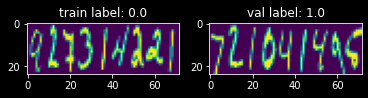

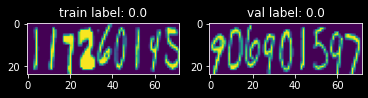

In [2]:
# Import Data
imagenet_data_train = torchvision.datasets.MNIST("./data/", train=True)  
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)
# data
n_digits = 9
window = (n_digits-3)//2
h_digit,w_digit = (24,8)
transform = transforms.Compose([transforms.CenterCrop((h_digit,20)),
                                transforms.Resize((h_digit,w_digit)),
                               ])
data = transform(imagenet_data_train.data)
data = data.repeat(n_digits,1,1)
mask = torch.randperm(data.shape[0])
data = data[mask].view(-1,n_digits,h_digit,w_digit) #Shuffle Data
data = data.permute(1,3,2,0).contiguous().view(w_digit*n_digits,h_digit,-1) #Concatenate digits
data = (data.permute(2,1,0).unsqueeze(1)/255)*2-1 # normalize data
targets = imagenet_data_train.targets.repeat(n_digits)
targets = targets[mask]
targets = targets.reshape(-1,n_digits)[:,window:-window].sum(axis=1)%2
#targets = 2*targets -1 
targets = targets.view(-1,1)
trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),
                                          batch_size=16,
                                          shuffle=True)
end = len(imagenet_data_val.data)//n_digits * n_digits
data = transform(imagenet_data_val.data[:end]).view(-1,n_digits,h_digit,w_digit) #[:-1]for 3 digits
data = data.permute(1,3,2,0).contiguous().view(w_digit*n_digits,h_digit,-1)
data = (data.permute(2,1,0).unsqueeze(1)/255)*2-1
targets = imagenet_data_val.targets[:end].view(-1,n_digits)[:,window:-window].sum(axis=1)%2 #[:-1] for 3 digits
#targets = 2*targets -1 
targets = targets.view(-1,1)
valloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),
                                          batch_size=16,
                                          shuffle=False)
xs,ys =  iter(trainloader).next()
xs2,ys2 =  iter(valloader).next()
i = 0
for x,y,x2,y2 in zip(xs,ys,xs2,ys2):
    i+=1
    fig, axes = plt.subplots(1,2)
    axes[0].set_title(f"train label: {y.item()}")
    axes[1].set_title(f"val label: {y2.item()}")
    axes[0].imshow(x[0])
    axes[1].imshow(x2[0])
    if i==2: break

In [10]:
filters_by_loc = list(lcn0.conv_blocks.parameters())[0]
filters_by_loc.shape[0]//nfilters

7

In [3]:
# Define training and validation functions
def train(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()
def validate(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat, y)
    return loss.item()
# Define metrics function
def Misalignment2(A,B,useAbasis=False):
    if useAbasis:
        evecA = A
    else:
        evalA,evecA = np.linalg.eig(A)
    M = 0
    for evec in evecA:
        a = np.dot(evec,np.matmul(B,evec))
        b = np.dot(evec,np.matmul(np.linalg.inv(B),evec))
        M += np.sqrt(a*b)-1
    return M
def cov2(filters):
    filters = filters.reshape(filters.shape[0],-1)
    cov_filters = np.matmul(filters.T,filters)
    return cov_filters
def get_misalignments(cnn,lcn,rand=None):
    filters_by_loc = list(lcn.conv_blocks.parameters())[0]
    span = filters_by_loc.shape[0]//nfilters
    filters_by_loc = filters_by_loc.unflatten(0,(nfilters,span)).cpu().squeeze().detach().numpy()
    filters = list(cnn.conv_blocks.parameters())[0].cpu().squeeze().detach().numpy()
    
    cov_filters_cnn = cov2(filters)
    missalignments = []
    if rand is not None:
         missalignments.append(Misalignment2(rand,
                                             cov2(filters_by_loc[:,span//2]),
                                             useAbasis=True))
    for i in range(span):
        cov_filters_lcn = cov2(filters_by_loc[:,i])
        missalignments.append(Misalignment2(cov_filters_cnn,cov_filters_lcn))
    return  missalignments
def train_loop2(models, T=10, log_step=1):
    losses_train = []
    losses_val = []
    rand, _ = np.linalg.qr(np.random.randn(h_digit*w_digit*3,h_digit*w_digit*3))
    for model in models:
        model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss0 = list()  # Combine losses from differetn steps in a single epoch
        loss1 = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss0_ = train(models[0], x, y)
            loss0.append(loss0_)
            loss1_ = train(models[1], x, y)
            loss1.append(loss1_)
            print(f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: [0] {loss0_:^.4f};"+
                  f" [1] {loss1_:^.4f}", end="\r")
        losses_train.append([loss0,loss1])
        loss0 = np.mean(loss0)
        loss1 = np.mean(loss1)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: [0] {loss0:^.4f}; [1] {loss1:^.4f} - "
            loss0 = []
            loss1 = []
            missalignments = []
            with torch.no_grad():
                for x, y in valloader:
                    loss0_ = validate(models[0], x, y)
                    loss1_ = validate(models[1], x, y)
                    loss0.append(loss0_)
                    loss1.append(loss1_)
            loss0 = np.mean(loss0)
            loss1 = np.mean(loss1)
            losses_val.append([loss0,loss1])
            message += f"Validation loss: [0] {loss0:^.4f}; [1] {loss1:^.4f}"
            miss = get_misalignments(models[0],models[1],rand=rand)
            missalignments.append(miss)
            message += "| Missalignment:" + " - ".join([f"{m:^.2f}" for m in miss])
            print(message)  # ,end="\r"
    return np.stack(losses_train), losses_val, missalignments

In [6]:
T = 30  # epochs
log_step = 1  # validate and print losses every log_steps
lr = 5e-4
criterion = torch.nn.MSELoss()
nfilters = 1024
stride=8
kernel_size = 24
hidden = 1024

In [14]:
filters_by_loc.flatten(2,3).shape

torch.Size([7168, 1, 576])

In [7]:
cnn0 = sym.models.CNN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Sigmoid())
cnn0.to(device)
cnn0.optimizer = torch.optim.Adam(cnn0.parameters(),lr=lr)
lcn0 = sym.models.LCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Sigmoid())
lcn0.to(device)
lcn0.optimizer = torch.optim.Adam(lcn0.parameters(),lr=lr)
losses_train, losses_val, missalign = train_loop2([cnn0,lcn0],T=T,log_step=log_step)

Epoch 001/30  | Training loss: [0] 0.2506; [1] 0.2508 - Validation loss: [0] 0.2500; [1] 0.2512| Missalignment:322.37 - 322.47 - 326.15 - 323.25 - 322.34 - 325.67 - 318.92 - 320.54
Epoch 002/30  | Training loss: [0] 0.2503; [1] 0.2503 - Validation loss: [0] 0.2503; [1] 0.2501| Missalignment:353.85 - 355.56 - 362.61 - 356.65 - 353.82 - 356.44 - 351.24 - 350.64
Epoch 003/30  | Training loss: [0] 0.2486; [1] 0.2497 - Validation loss: [0] 0.2454; [1] 0.2484| Missalignment:409.22 - 393.24 - 404.08 - 396.60 - 409.20 - 402.60 - 392.54 - 388.62
Epoch 004/30  | Training loss: [0] 0.1943; [1] 0.2242 - Validation loss: [0] 0.1570; [1] 0.2008| Missalignment:506.64 - 440.66 - 461.58 - 467.45 - 506.96 - 460.85 - 446.81 - 432.74
Epoch 005/30  | Training loss: [0] 0.1257; [1] 0.1740 - Validation loss: [0] 0.0974; [1] 0.1328| Missalignment:554.56 - 473.07 - 506.55 - 521.23 - 554.65 - 508.30 - 489.67 - 463.86
Epoch 006/30  | Training loss: [0] 0.0928; [1] 0.1220 - Validation loss: [0] 0.0890; [1] 0.1104